In [13]:
from pypinyin import lazy_pinyin, Style
import torch

MODELS = {
    'vqvae.pth':'/home/hyc/tortoise_plus_zh/ttts/vqvae/logs/2023-11-04-15-44-23/model-36.pt',
    'gpt.pth': '/home/hyc/tortoise_plus_zh/ttts/gpt/logs/2023-11-05-21-44-13/model-9.pt',
    'clvp2.pth': '',
    'diffusion.pth': '/home/hyc/tortoise_plus_zh/ttts/diffusion/logs/2023-10-27-00-00-28/model-12.pt',
    'vocoder.pth': '/home/hyc/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin',
    'rlg_auto.pth': '',
    'rlg_diffuser.pth': '',
}

In [14]:
from ttts.gpt.voice_tokenizer import VoiceBpeTokenizer
import torch.nn.functional as F
device = 'cuda:1'
# text = "大家好今天来点大家想看的东西。"
text = "霞浦县衙城镇乌旗瓦窑村水位猛涨。"
pinyin = ' '.join(lazy_pinyin(text, style=Style.TONE3, neutral_tone_with_five=True))
tokenizer = VoiceBpeTokenizer('gpt/gpt_tts_tokenizer.json')
text_tokens = torch.IntTensor(tokenizer.encode(pinyin)).unsqueeze(0).to(device)
text_tokens = F.pad(text_tokens, (0, 1))  # This may not be necessary.
text_tokens = text_tokens.to(device)
print(pinyin)
print(text_tokens)

xia2 pu3 xian4 ya2 cheng2 zhen4 wu1 qi2 wa3 yao2 cun1 shui3 wei4 meng3 zhang3 。
tensor([[ 62, 162,   2,  24,  60,   2, 167,   2,  33, 162,   2, 147,   2,  53,
         150,   2,  31,  80,   2,  25,  58,   2,  31, 125,   2,  33, 194,   2,
          11,  29,  91,   2, 246,  59,   2, 140,   2,  21, 238,   2,  53,  92,
           2,  39,   0]], device='cuda:1', dtype=torch.int32)


In [15]:
from ttts.utils.infer_utils import load_model
from ttts.vocoder.feature_extractors import MelSpectrogramFeatures
import torchaudio
# device = 'gpu:0'
gpt = load_model('gpt',MODELS['gpt.pth'],'gpt/config.json',device)
gpt.post_init_gpt2_config(use_deepspeed=False, kv_cache=False, half=False)
# diffusion = load_model('diffusion',MODELS['diffusion.pth'],'ttts/diffusion/config.json',device)
cond_audio = '0.wav'
audio,sr = torchaudio.load(cond_audio)
if audio.shape[0]>1:
    audio = audio[0].unsqueeze(0)
audio = torchaudio.transforms.Resample(sr,24000)(audio)
cond_mel = MelSpectrogramFeatures()(audio).to(device)
print(cond_mel.shape)

torch.Size([1, 100, 433])


In [22]:
auto_conditioning = cond_mel
settings = {'temperature': .8, 'length_penalty': 1.0, 'repetition_penalty': 2.0,
                    'top_p': .8,
                    'cond_free_k': 2.0, 'diffusion_temperature': 1.0}
top_p = .8
temperature = .8
autoregressive_batch_size = 1
length_penalty = 1.0
repetition_penalty = 2.0
max_mel_tokens = 600
print(auto_conditioning.shape)
print(text_tokens.shape)
# text_tokens = F.pad(text_tokens,(0,400-text_tokens.shape[1]),value=0)
print(text_tokens.shape)
codes = gpt.inference_speech(auto_conditioning, text_tokens,
                                do_sample=True,
                                top_p=top_p,
                                temperature=temperature,
                                num_return_sequences=autoregressive_batch_size,
                                length_penalty=length_penalty,
                                repetition_penalty=repetition_penalty,
                                max_generate_length=max_mel_tokens)
print(codes)

torch.Size([1, 100, 433])
torch.Size([1, 45])
torch.Size([1, 45])
tensor([[ 448, 4014, 5555, 2356, 6851,  363, 4505,  343, 1914, 7705, 1028, 2489,
         2947, 2772, 7311, 1793, 1945, 1140,  296, 1479, 4168, 1033, 6415, 4377,
         2774, 6401, 4889, 6776, 4362, 5623, 1371, 1447,  827, 1065, 3250, 5491,
         7077, 2551, 3053, 3891, 2858, 5730, 8039, 6230, 5412,  268, 4451, 6372,
         2618, 5279, 1993, 2935, 2037, 5010,  579,   25, 1785, 3409,  903, 7423,
          944, 4581,  851, 2387, 2397, 3324,  165, 6150, 7626, 1478,  499, 1253,
         6408, 3733, 2980, 6486,  573, 2019,  233, 7800, 3031, 5770, 3166,   39,
         3099, 6468,  159,  580,   87,  256, 1113, 5503, 1031, 7205, 7435,  462,
            0, 8193]], device='cuda:1')


In [23]:
vqvae = load_model('vqvae', MODELS['vqvae.pth'], 'vqvae/config.json', device)
mel = vqvae.decode(codes[:,:-1])[0]
codes_gt = vqvae.get_codebook_indices(cond_mel)
print(codes_gt)
mel.shape

tensor([[ 448,  448,  448, 7200, 6851,  363, 4505,  343, 1914, 7705, 1028, 2489,
         2947, 2772, 7311, 1793, 1945, 1140,  296, 1479, 4168, 1033, 6415, 4377,
         2774, 6401, 4889, 6776, 4362, 5623, 1371, 1447,  827, 1065, 3250, 5491,
         7077, 2551, 3053, 3891, 2858, 5730, 8039, 6230, 5412,  268, 4451, 6372,
         2618, 5279, 1993, 2935, 2037, 5010,  579,   25, 1785, 3409,  903,  827,
         7447,  239,  791, 5961, 4027,  367, 3228, 6408, 2332, 3372, 2993, 4765,
         3272, 5418, 7423, 1362, 2461, 1331,  233, 7800, 4168, 3350, 6363, 2871,
         4305, 1288,  625, 6692, 5763, 1800, 2097, 7626, 5501,  756,  121, 3676,
         6205, 5077, 5778, 3126,  494,  882,  965, 3715, 6268, 5580, 2804, 3692,
         5230]], device='cuda:1')


torch.Size([1, 100, 388])

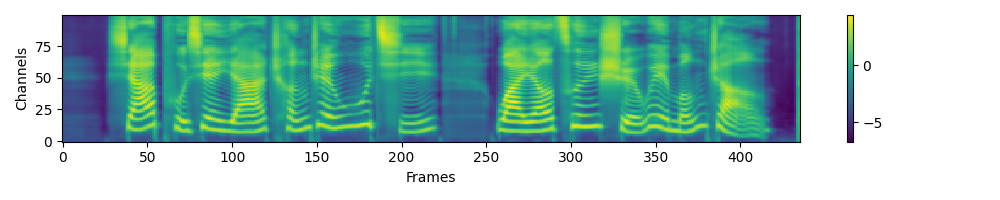

In [20]:
from PIL import Image
import numpy as np
from IPython.display import display
from ttts.utils.utils import plot_spectrogram_to_numpy
img = plot_spectrogram_to_numpy(mel[0, :, :].detach().unsqueeze(-1).cpu())
image = Image.fromarray(np.uint8(img))
display(image)

In [24]:
from ttts.vocoder.vocos import Vocos


vocos = Vocos.from_pretrained('pretrained_models/pytorch_model.bin','vocoder/config.yaml').to(device)
audio = vocos.decode(mel)
print(audio.shape)
torchaudio.save('gen.wav',audio.detach().cpu(), 24000)

torch.Size([1, 99072])


In [25]:
latent = gpt(auto_conditioning, text_tokens,
    torch.tensor([text_tokens.shape[-1]], device=text_tokens.device), codes,
    torch.tensor([codes.shape[-1]*gpt.mel_length_compression], device=text_tokens.device),
    return_latent=True, clip_inputs=False)
latent.shape

torch.Size([1, 123, 1024])

In [ ]:

mel = do_spectrogram_diffusion(diffusion, diffuser, latents, diffusion_conditioning, temperature=diffusion_temperature, 
                                                    verbose=verbose)
                        wav = vocoder.inference(mel)

In [33]:
from ttts.vocoder.vocos import Vocos
from IPython.display import Audio
vocoder = Vocos.from_pretrained("/home/hyc/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin","/home/hyc/tortoise_plus_zh/ttts/vocoder/config.yaml")
audio = vocoder.decode(mel.cpu())
torchaudio.save('gen_0.wav',audio,24000)
Audio('gen_0.wav')